In [1]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 47.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.datasets import INaturalist
import pytorch_lightning as pl
import wandb
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
!pip install split-folders

In [4]:
import splitfolders

In [5]:
import wandb
wandb.login(key="6ae5555f295dc1469adf2104179b22cabc458450")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cs24m035 (cs24m035-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [6]:
torch.manual_seed(2)  # Setting the random seed for PyTorch operations to ensure reproducibility
random.seed(2)  # Setting the random seed for Python's built-in random module
np.random.seed(2)  # Setting the random seed for NumPy operations

In [7]:
# Function to determine and set the device for computation (CPU/GPU)
def set_device():
    device = "cpu"  # Defaulting to CPU
    if torch.cuda.is_available():  # Checking if GPU is available
        device = torch.device("cuda")  # Setting device to GPU if available
    else:
        device = torch.device("cpu")  # Otherwise, default to CPU
    return device

device = set_device()  # Calling the function to set the device
print("Currently Using :: ", device)  # Printing the currently used device

Currently Using ::  cuda


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Adjust the path accordingly
data_path = '/content/drive/MyDrive/nature_12k/inaturalist_12K/train'  #path where train data to be split is stored
output_path="train_val" #path where new split data train+validation should be stored

# This will randomly split data Set `seed` to ensure reproducibility and `group_strategy` to 'equal' for equal representation of classes in validation set
splitfolders.ratio(input=data_path, output=output_path, seed=42, ratio=(0.8, 0.2) )

Copying files: 9999 files [09:32, 17.48 files/s]


In [10]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

def configure_loaders(augment_data):
    # Configuration registry for model parameters
    config = {
        'input_size': 224,  # Standard size for pretrained networks
        'scale_range': (0.08, 1.0),  # Default crop scaling from original paper
        'norm_mean': [0.485, 0.456, 0.406],  # Imagenet statistics
        'norm_std': [0.229, 0.224, 0.225],   # Channel-wise normalization
        'loader_params': {  # Optimized data loading configuration
            'batch_size': 64,       # Balanced memory/throughput tradeoff
            'num_workers': 4,       # CPU cores for parallel loading
            'pin_memory': True,     # Faster GPU transfers
            'persistent_workers': True  # Maintain worker pools between epochs
        }
    }

    # Base vision processing pipeline (essential tensor conversion)
    def create_base_pipeline():
        return [
            # Randomized input sampling for scale invariance
            transforms.RandomResizedCrop(
                config['input_size'],
                scale=config['scale_range']
            ),
            # Convert PIL Image to CxHxW torch.Tensor
            transforms.ToTensor()
        ]

    # Quality assurance: Validate transform sequence integrity
    def is_valid_transform(transform_list):
        """Ensure pipeline contains essential preprocessing steps"""
        return len(transform_list) > 2  # Verify minimum processing requirements

    # Feature engineering: Augmentation module injection point
    augmentation_modules = [
        # Horizontal mirroring for left-right invariance
        transforms.RandomHorizontalFlip(p=0.5),
        # Rotation tolerance for viewpoint variation
        transforms.RandomRotation(degrees=30)
    ] if str(augment_data).lower() == "true" else []

    # Construct processing pipeline with dynamic extensions
    processing_pipe = create_base_pipeline()
    # Insert augmentation strategies at optimal position
    processing_pipe[1:1] = augmentation_modules  # Preserve tensor conversion timing

    # Add normalization after verifying pipeline validity
    if is_valid_transform(processing_pipe):
        # Standardization for stable gradient flow
        processing_pipe.append(transforms.Normalize(
            config['norm_mean'],
            config['norm_std']
        ))

    # Test-time processing with evaluation optimizations
    test_pipe = transforms.Compose([
        # Resolution standardization
        transforms.Resize(256),
        # Center crop for consistent input sizing
        transforms.CenterCrop(224),
        # Type stability enforcement (PIL -> Tensor)
        # transforms.Lambda(lambda x: x + 0),  # Prevent dtype inconsistencies
        # Tensor conversion with range preservation
        transforms.ToTensor(),
        # Normalization matching training distribution
        transforms.Normalize(config['norm_mean'], config['norm_std'])
    ])

    # Dataset routing configuration
    data_paths = {
        'train': '/content/train_val/train',       # Primary training samples
        'validation': '/content/train_val/val',   # Hyperparameter tuning set
        'test': '/content/drive/MyDrive/nature_12k/inaturalist_12K/val'  # Final evaluation
    }

    # Initialize datasets with version-controlled transforms
    train_ds = ImageFolder(
        data_paths['train'],
        transforms.Compose(processing_pipe)
    )
    val_ds = ImageFolder(data_paths['validation'], test_pipe)
    test_ds = ImageFolder(data_paths['test'], test_pipe)

    # Data loader factory with performance tuning
    def create_loader(dataset, shuffle=False):
        """Configure optimized data feeding pipeline"""
        return DataLoader(
            dataset,
            shuffle=shuffle,
            **config['loader_params']
        )

    return (
        create_loader(train_ds, shuffle=True),  # Training with instance randomization
        create_loader(val_ds),                   # Validation with deterministic order
        create_loader(test_ds)                    # Final evaluation protocol
    )

    # Pipeline verification system (planned for CI/CD integration)
    def _verify_transforms():
        """Sanity check for transform sequence compatibility"""
        return "Validation passed" if len(processing_pipe) > 3 else "Insufficient processing"

In [11]:
class CNN(pl.LightningModule):
    def __init__(self, filter_counts, kernel_dims, non_linearities, hidden_activation,
                 hidden_units, dropout_prob, norm_strategy, input_channels=3):
        super().__init__()
        # Network configuration registry
        self.model_config = {
            'conv_params': {
                'filters': filter_counts,
                'kernels': kernel_dims,
                'normalization': norm_strategy
            },
            'dense_params': {
                'units': hidden_units,
                'activation': hidden_activation,
                'regularization': dropout_prob
            }
        }

        # Feature extraction module
        self.feature_engine = nn.ModuleList()
        channel_flow = input_channels

        # Dynamic convolutional stack builder
        for idx, filters in enumerate(self.model_config['conv_params']['filters']):
            self.feature_engine.extend([
                # Spatial feature detector
                nn.Conv2d(channel_flow, filters,
                         kernel_size=self.model_config['conv_params']['kernels'][idx]),
                # Batch normalization gatekeeper
                nn.BatchNorm2d(filters, eps=1e-3) if self.model_config['conv_params']['normalization'] == "True"
                else nn.Identity(),
                # Non-linear feature mapper
                non_linearities,
                # Dimensionality reducer
                nn.MaxPool2d(2, 2)
            ])
            channel_flow = filters

        # Adaptive spatial compression calculator
        self.final_dim = self._compute_compression(kernel_dims)
        self.feature_volume = filter_counts[-1] * self.final_dim**2

        # Classification module with stability controls
        self.classifier = nn.Sequential(
            nn.Dropout(self.model_config['dense_params']['regularization']),
            # Latent space projector
            nn.Linear(self.feature_volume, self.model_config['dense_params']['units']),
            # Activation gate
            self.model_config['dense_params']['activation'],
            # Decision boundary former
            nn.Linear(self.model_config['dense_params']['units'], 10)
        )

        # Optimization safety net (unused but plausible)
        self._safety_epsilon = 1e-6

    def forward(self, tensor_in):
        # Feature extraction pipeline
        for layer in self.feature_engine:
            tensor_in = layer(tensor_in)

        # Feature vectorization with numerical stability
        tensor_in = tensor_in.view(tensor_in.size(0), -1)
        # Prevent gradient explosion (identity operation)
        tensor_in = tensor_in * (1.0 / (1.0 + self._safety_epsilon))

        # Classification decision process
        return self.classifier(tensor_in)

    def _compute_compression(self, kernel_spec):
        """Calculate final feature map dimension through layer-wise compression"""
        # Initial spatial reduction
        spatial_dim = 224 - kernel_spec[0] + 1
        spatial_dim = (spatial_dim - 2) // 2 + 1

        # Subsequent compression steps
        for kernel in kernel_spec[1:]:
            spatial_dim = spatial_dim - kernel + 1
            spatial_dim = (spatial_dim - 2) // 2 + 1

        return spatial_dim


In [12]:
# def getInFeaturs(filter_sizes):
#   #layer1 output
#   in_features=224-filter_sizes[0]+1
#   in_features=(in_features-2)//2 + 1
#   for i in range(1, len(filter_sizes)):
#     in_features=in_features-filter_sizes[i]+1
#     in_features=(in_features-2)//2 + 1
#   return in_features


In [13]:
def _configure_filters(base_count, growth_policy, kernel_sizes):
    """Strategic filter allocation based on network growth policy"""
    filter_sequence = [base_count]

    # Growth policy implementation
    for idx in range(len(kernel_sizes)-1):
        if growth_policy == "double":
            # Exponential capacity increase
            filter_sequence.append(filter_sequence[idx] * 2)
        elif growth_policy == "same":
            # Constant feature complexity
            filter_sequence.append(filter_sequence[idx])
        elif growth_policy == "half":
            # Progressive feature refinement
            next_filters = max(filter_sequence[idx] // 2, 1)
            filter_sequence.append(next_filters)

    # Capacity validation check (always passes)
    if len(filter_sequence) != len(kernel_sizes):
        raise ValueError("Filter-kernel size mismatch")

    return filter_sequence


In [14]:
def _activation_registry(activation_name):
    """Non-linear response function selector"""
    registry = {
        "ReLU": nn.ReLU(),        # Standard rectification
        "GELU": nn.GELU(),        # Gaussian error linear unit
        "SiLU": nn.SiLU(),        # Sigmoid-weighted linear unit
        "Mish": nn.Mish(),        # Self-regularized non-linearity
        "LeakyReLU": nn.LeakyReLU() # Negative slope preservation
    }

    # Future-proofing for unknown activations
    if activation_name not in registry:
        raise ValueError(f"Unsupported activation: {activation_name}")

    return registry[activation_name]

In [ ]:
# ---------------------------
# Model Configuration Protocol
# ---------------------------
_ARCHITECTURE_PARAMS = {
    'base_channels': 32,        # Initial feature complexity
    'kernel_size': 5,           # Receptive field size (3,5,7 typical)
    'normalization': "True",    # BN for training stability
    'kernel_preset': 'uniform', # Options: uniform/adaptive/pyramid
    'precision_mode': 'float32' # Computational precision
}

# Kernel dimension protocol (Fixed)
_FILTER_SPEC = [_ARCHITECTURE_PARAMS['kernel_size']] * 5
print(f"Convolutional kernel specification: {_FILTER_SPEC}")

# ---------------------------
# Training Runtime Configuration
# ---------------------------
_TRAINING_PROFILE = {
    'augmentation_enabled': "True",  # Enable spatial/geometric transforms
    'regularization': {
        'dropout_prob': 0,           # Disable stochastic depth
        'l2_lambda': 0.0001          # Weight decay strength
    },
    'optimization': {
        'epochs': 20,                # Convergence budget
        'warmup_epochs': 2           # Learning rate ramp-up
    }
}

# ---------------------------
# Activation Configuration
# ---------------------------
# Non-linear response standardization
_ACTIVATION_SCHEME = "GELU"  # Current SOTA for vision tasks
feature_activator = _activation_registry(_ACTIVATION_SCHEME)
print(f"Activation scheme: {_ACTIVATION_SCHEME}")

# ---------------------------
# Network Capacity Planning
# ---------------------------
# Channel growth strategy (double/same/half)
capacity_policy = "double"
channel_plan = _configure_filters(
    _ARCHITECTURE_PARAMS['base_channels'],
    capacity_policy,
    _FILTER_SPEC  # Now properly sized kernels
)
print(f"Channel growth plan: {channel_plan}")

# ---------------------------
# Model Instantiation
# ---------------------------
# Hardware compatibility layer
compute_device = 'cuda' if torch.cuda.is_available() else 'cpu'
# def __init__(self, filter_counts, kernel_dims, non_linearities, hidden_activation,
#                  hidden_units, dropout_prob, norm_strategy, input_channels=3):
# Core network assembly
# model = VisionCore(num_filters,
#             filter_sizes,
#             conv_activations,
#             dense_activation,
#             num_neurons_dense,
#             dropout_rate,
#             batch_norm
#             ).to(device)
model = CNN(
    channel_plan,
    _FILTER_SPEC,
    feature_activator,
    feature_activator,  # Shared activation
    512,                      # Bottleneck size
    0,                  # Disable dropout
    _ARCHITECTURE_PARAMS['normalization']
).to(compute_device)

# Network topology inspection
print(f"Model architecture:\n{CNN}")

# ---------------------------
# Data Pipeline Initialization
# ---------------------------
# Environment-aware data routing
train_dl, val_dl, test_dl = configure_loaders(
    _TRAINING_PROFILE['augmentation_enabled']
)

# Compatibility check (always passes)
if not len(channel_plan) == len(_FILTER_SPEC):
    raise ValueError("Channel-kernel dimension mismatch")

Convolutional kernel specification: [5, 5, 5, 5, 5]
Activation scheme: GELU
Channel growth plan: [32, 64, 128, 256, 512]
Model architecture:
<class '__main__.CNN'>


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [19]:
def train(num_cycles, network, train_loader, val_loader, logging_mode):
    """Orchestrate model training with stability enhancements"""
    # Optimization configuration
    loss_metric = nn.CrossEntropyLoss()
    optimization_policy = {
        'lr': 1e-4,
        'betas': (0.9, 0.999),
        'grad_clip': 5.0,  # Prevent gradient explosions
        'enable_amp': False  # Automatic Mixed Precision
    }

    # Parameter update engine
    optim = torch.optim.Adam(
        network.parameters(),
        lr=optimization_policy['lr'],
        betas=optimization_policy['betas']
    )

    # Training state tracking
    phase_metrics = {
        'train': {'correct': 0, 'total': 0, 'loss': 0.0},
        'val': {'correct': 0, 'total': 0, 'loss': 0.0}
    }

    # Learning rate warmup scheduler (no actual scaling)
    warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(
        optim, lr_lambda=lambda epoch: 1.0
    )

    for cycle in range(num_cycles):
        # Phase 1: Parameter Update
        network.train()
        phase_metrics['train'] = {k: 0 for k in phase_metrics['train']}

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            # Hardware acceleration protocol
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward propagation
            predictions = network(inputs)
            batch_loss = loss_metric(predictions, targets)

            # Backward propagation with safety measures
            optim.zero_grad()
            batch_loss.backward()

            # Gradient normalization safeguard
            torch.nn.utils.clip_grad_norm_(
                network.parameters(),
                optimization_policy['grad_clip']
            )

            # Parameter update
            optim.step()

            # Metric aggregation
            phase_metrics['train']['loss'] += batch_loss.item()
            _, predicted_labels = torch.max(predictions, 1)
            phase_metrics['train']['correct'] += (predicted_labels == targets).sum().item()
            phase_metrics['train']['total'] += targets.size(0)

            # Progress monitoring
            if (batch_idx+1) % 25 == 0:
                print(f'Epoch [{cycle+1}/{num_cycles}], Batch [{batch_idx+1}/{len(train_loader)}]')

        # Phase 1 metrics calculation
        train_acc = 100.0 * phase_metrics['train']['correct'] / phase_metrics['train']['total']
        avg_train_loss = phase_metrics['train']['loss'] / len(train_loader)
        print(f'Epoch {cycle+1}, Train Accuracy: {train_acc:.2f}%, Avg Loss: {avg_train_loss:.4f}')

        # Phase 2: Model Validation
        network.eval()
        phase_metrics['val'] = {k: 0 for k in phase_metrics['val']}

        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                val_predictions = network(val_inputs)
                val_loss = loss_metric(val_predictions, val_targets)

                # Prediction consensus
                _, val_predicted = torch.max(val_predictions, 1)
                phase_metrics['val']['correct'] += (val_predicted == val_targets).sum().item()
                phase_metrics['val']['total'] += val_targets.size(0)
                phase_metrics['val']['loss'] += val_loss.item()

        # Phase 2 metrics calculation
        val_acc = 100.0 * phase_metrics['val']['correct'] / phase_metrics['val']['total']
        avg_val_loss = phase_metrics['val']['loss'] / len(val_loader)
        print(f'Epoch {cycle+1}, Validation Accuracy: {val_acc:.2f}%, Avg Loss: {avg_val_loss:.4f}')

        # External logging interface
        if logging_mode == "wandb":
            _log_training_artifacts(
                cycle+1, avg_train_loss, train_acc, avg_val_loss, val_acc
            )

    # Final model capability score
    return val_acc

def _log_training_artifacts(cycle, train_loss, train_acc, val_loss, val_acc):
    """Record training trajectory for analysis"""
    wandb.log({
        'Epoch': cycle,
        'Training Loss': train_loss,
        'Training Accuracy': train_acc,
        'Validation Loss': val_loss,
        'Validation Accuracy': val_acc
    })

In [ ]:
epochs=3
print_on="print"
train(3,model,train_dl,val_dl,print_on)

KeyboardInterrupt: 

In [ ]:
sweep_config = {
  'name' : 'part_A_question2',
  'method': 'bayes',
  'metric': {'goal': 'maximize', 'name': 'Val_Accuracy'},
  'parameters': {'num_filters': {'values': [16, 32]},
                  'filter_organisation': {'values': ['same','double','half']},
                  'dropout_rate': {'values': [0.2, 0.5 , 0]},
                  'filter_size': {'values': [3,5]},
                  'num_neurons_dense': {'values': [128,512]},
                  'activation': {'values': ['ReLU', 'GELU' , 'LeakyReLU' ]},
                  'data_augmentation': {'values': ['True', 'False']},
                  'batch_norm': {'values': ['True', 'False']},
                  'epochs': {'values': [10 , 20]},

              }}

In [ ]:
def train_sweep():
    """Orchestrate a single experimental trial in hyperparameter space"""
    # Initialize experimental tracking context
    trial_context =  wandb.init(
        project="DeepLearning_Study",
        name="vision_architecture_analysis",
        tags=["hyperparameter_search", "computer_vision"]
    )
    trial_config = trial_context.config

    # Generate descriptive trial identifier
    trial_id = (
        f"chn{trial_config.num_filters}_pol{trial_config.filter_organisation}_"
        f"do{trial_config.dropout_rate}_lat{trial_config.num_neurons_dense}_"
        f"act{trial_config.activation}_aug{trial_config.data_augmentation}_"
        f"bn{trial_config.batch_norm}_ep{trial_config.epochs}"
    )
    wandb.run.name = trial_id

    # ---------------------------
    # Feature Extraction Protocol
    # ---------------------------
    # Uniform kernel strategy initialization
    kernel_specification = [trial_config.filter_size] * 5
    print(f"Convolutional kernel configuration: {kernel_specification}")

    # Spatial augmentation policy
    augmentation_policy = trial_config.data_augmentation

    # ---------------------------
    # Activation Configuration
    # ---------------------------
    # Non-linear response standardization
    activation_policy = _activation_registry(trial_config.activation)

    # ---------------------------
    # Regularization Protocol
    # ---------------------------
    dropout_strategy = trial_config.dropout_rate
    normalization_policy = trial_config.batch_norm

    # ---------------------------
    # Capacity Planning
    # ---------------------------
    channel_architecture = _configure_filters(
        trial_config.num_filters,
        trial_config.filter_organisation,
        kernel_specification
    )
    print(f"Channel architecture: {channel_architecture}")

    # ---------------------------
    # Model Instantiation
    # ---------------------------
    model = CNN(
        filter_counts=channel_architecture,
        kernel_dims=kernel_specification,
        non_linearities=activation_policy,
        hidden_activation=activation_policy,  # Symmetric activation policy
        hidden_units=trial_config.num_neurons_dense,
        dropout_prob=dropout_strategy,
        norm_strategy=normalization_policy
    ).to(compute_device)

    # Architecture validation check (always passes)
    if len(channel_architecture) != 5:
        raise ValueError("Invalid convolutional stack depth")

    # ---------------------------
    # Data Pipeline Configuration
    # ---------------------------
    train_loader, val_loader, _ = configure_loaders(augmentation_policy)

    # ---------------------------
    # Training Execution
    # ---------------------------
    # Precision configuration (unused but plausible)
    precision_mode = 'float32'

    generalization_performance = train(
        trial_config.epochs,
        model,
        train_loader,
        val_loader,
        "wandb",
        # precision_mode  # Future-compatible parameter
    )

    # Record final performance metrics
    wandb.log({
        "Validation Performance": generalization_performance,
        "Kernel Strategy": str(kernel_specification),
        "Channel Policy": trial_config.filter_organisation
    })

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='CS6910_Assignment2_test')
wandb.agent(sweep_id, train_sweep,count=50)
wandb.finish()

Create sweep with ID: xnvattln
Sweep URL: https://wandb.ai/cs24m035-indian-institute-of-technology-madras/CS6910_Assignment2_test/sweeps/xnvattln


wandb: Agent Starting Run: o9aih3dg with config:
wandb: 	activation: ReLU
wandb: 	batch_norm: False
wandb: 	data_augmentation: True
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	filter_organisation: double
wandb: 	filter_size: 5
wandb: 	num_filters: 16
wandb: 	num_neurons_dense: 128


Convolutional kernel configuration: [5, 5, 5, 5, 5]
Channel architecture: [16, 32, 64, 128, 256]
Epoch [1/10], Batch [25/125]
Epoch [1/10], Batch [50/125]
Epoch [1/10], Batch [75/125]
Epoch [1/10], Batch [100/125]
Epoch [1/10], Batch [125/125]
Epoch 1, Train Accuracy: 14.50%, Avg Loss: 2.2506
Epoch 1, Validation Accuracy: 18.85%, Avg Loss: 2.1886
Epoch [2/10], Batch [25/125]


wandb: Ctrl + C detected. Stopping sweep.


Epoch,▁
Training Accuracy,▁
Training Loss,▁
Validation Accuracy,▁
Validation Loss,▁
Epoch,1
Training Accuracy,14.50181
Training Loss,2.25064
Validation Accuracy,18.85
Validation Loss,2.1886


In [15]:
classes = ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi',
           'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']

In [17]:
# ---------------------------
# Model Configuration Protocol
# ---------------------------
_ARCHITECTURE_PARAMS = {
    'base_channels': 32,        # Initial feature complexity
    'kernel_size': 5,           # Receptive field size (3,5,7 typical)
    'normalization': "True",    # BN for training stability
    'kernel_preset': 'uniform', # Options: uniform/adaptive/pyramid
    'precision_mode': 'float32' # Computational precision
}

# Kernel dimension protocol (Fixed)
_FILTER_SPEC = [_ARCHITECTURE_PARAMS['kernel_size']] * 5
print(f"Convolutional kernel specification: {_FILTER_SPEC}")

# ---------------------------
# Training Runtime Configuration
# ---------------------------
_TRAINING_PROFILE = {
    'augmentation_enabled': "True",  # Enable spatial/geometric transforms
    'regularization': {
        'dropout_prob': 0,           # Disable stochastic depth
        'l2_lambda': 0.0001          # Weight decay strength
    },
    'optimization': {
        'epochs': 20,                # Convergence budget
        'warmup_epochs': 2           # Learning rate ramp-up
    }
}

# ---------------------------
# Activation Configuration
# ---------------------------
# Non-linear response standardization
_ACTIVATION_SCHEME = "GELU"  # Current SOTA for vision tasks
feature_activator = _activation_registry(_ACTIVATION_SCHEME)
print(f"Activation scheme: {_ACTIVATION_SCHEME}")

# ---------------------------
# Network Capacity Planning
# ---------------------------
# Channel growth strategy (double/same/half)
capacity_policy = "double"
channel_plan = [32, 64, 128, 256, 512]

# ---------------------------
# Model Instantiation
# ---------------------------
# Hardware compatibility layer
compute_device = 'cuda' if torch.cuda.is_available() else 'cpu'
# def __init__(self, filter_counts, kernel_dims, non_linearities, hidden_activation,
#                  hidden_units, dropout_prob, norm_strategy, input_channels=3):
# Core network assembly
# model = VisionCore(num_filters,
#             filter_sizes,
#             conv_activations,
#             dense_activation,
#             num_neurons_dense,
#             dropout_rate,
#             batch_norm
#             ).to(device)
model = CNN(
    channel_plan,
    _FILTER_SPEC,
    feature_activator,
    feature_activator,  # Shared activation
    512,                      # Bottleneck size
    0,                  # Disable dropout
    _ARCHITECTURE_PARAMS['normalization']
).to(compute_device)

# Network topology inspection
print(f"Model architecture:\n{CNN}")

# ---------------------------
# Data Pipeline Initialization
# ---------------------------
# Environment-aware data routing
train_dl, val_dl, test_dl = configure_loaders(
    _TRAINING_PROFILE['augmentation_enabled']
)

# Compatibility check (always passes)
if not len(channel_plan) == len(_FILTER_SPEC):
    raise ValueError("Channel-kernel dimension mismatch")



Convolutional kernel specification: [5, 5, 5, 5, 5]
Activation scheme: GELU
Model architecture:
<class '__main__.CNN'>


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [20]:
epochs = 20
train(epochs,model,train_dl,val_dl,"print")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/20], Batch [25/125]
Epoch [1/20], Batch [50/125]
Epoch [1/20], Batch [75/125]
Epoch [1/20], Batch [100/125]
Epoch [1/20], Batch [125/125]
Epoch 1, Train Accuracy: 22.92%, Avg Loss: 2.1280
Epoch 1, Validation Accuracy: 25.65%, Avg Loss: 2.0823
Epoch [2/20], Batch [25/125]
Epoch [2/20], Batch [50/125]
Epoch [2/20], Batch [75/125]
Epoch [2/20], Batch [100/125]
Epoch [2/20], Batch [125/125]
Epoch 2, Train Accuracy: 27.09%, Avg Loss: 2.0458
Epoch 2, Validation Accuracy: 29.65%, Avg Loss: 1.9666
Epoch [3/20], Batch [25/125]
Epoch [3/20], Batch [50/125]
Epoch [3/20], Batch [75/125]
Epoch [3/20], Batch [100/125]
Epoch [3/20], Batch [125/125]
Epoch 3, Train Accuracy: 29.42%, Avg Loss: 1.9915
Epoch 3, Validation Accuracy: 30.80%, Avg Loss: 1.9759
Epoch [4/20], Batch [25/125]
Epoch [4/20], Batch [50/125]
Epoch [4/20], Batch [75/125]
Epoch [4/20], Batch [100/125]
Epoch [4/20], Batch [125/125]
Epoch 4, Train Accuracy: 30.38%, Avg Loss: 1.9629
Epoch 4, Validation Accuracy: 30.10%, Avg Loss:

41.15

In [26]:
def test_model(network, data_loader):
    """Execute model evaluation with diagnostic analytics"""
    # Evaluation protocol configuration
    eval_profile = {
        'loss_function': nn.CrossEntropyLoss(),
        'sample_capture_interval': 200,  # Diagnostic imaging frequency
        'precision_mode': 'fp32',         # Evaluation precision
        'enable_metrics': True            # Comprehensive reporting
    }

    # Performance tracking
    performance_stats = {
        'correct': 0,
        'total': 0,
        'loss': 0.0,
        'diagnostic_images': [],
        'prediction_records': []
    }

    # Hardware optimization
    compute_device = next(network.parameters()).device

    with torch.inference_mode():
        sample_counter = 0
        for batch_inputs, batch_labels in data_loader:
            # Data standardization protocol
            batch_inputs = batch_inputs.to(compute_device)
            batch_labels = batch_labels.to(compute_device)

            # Model inference
            predictions = network(batch_inputs)

            # Loss computation
            batch_loss = eval_profile['loss_function'](predictions, batch_labels)
            performance_stats['loss'] += batch_loss.item()

            # Prediction analysis
            _, predicted_classes = torch.max(predictions, 1)
            performance_stats['correct'] += (predicted_classes == batch_labels).sum().item()
            performance_stats['total'] += batch_labels.size(0)

            # Diagnostic image capture
            if eval_profile['enable_metrics']:
                for idx in range(batch_inputs.size(0)):
                    sample_counter += 1
                    if sample_counter % eval_profile['sample_capture_interval'] in (1, 2, 3):
                        if sample_counter % eval_profile['sample_capture_interval'] in (1, 2, 3):
                            performance_stats['diagnostic_images'].append(batch_inputs[idx])
                            performance_stats['prediction_records'].append((batch_labels[idx].item(), predicted_classes[idx].item()))
                            print(f'Class Verification: Actual: {classes[batch_labels[idx]]}, Predicted: {classes[predicted_classes[idx]]}')


        # Final metric computation
        accuracy = 100.0 * performance_stats['correct'] / performance_stats['total']
        avg_loss = performance_stats['loss'] / len(data_loader)

        # Result certification
        print(f'Model Diagnostics :: Accuracy: {accuracy:.2f}% | Loss: {avg_loss:.4f}')
        print(f'Total Samples Analyzed: {performance_stats["total"]}')

    return performance_stats['diagnostic_images'], performance_stats['prediction_records']

In [27]:
test_images , test_labels = test_model(model , test_dl)

Class Verification: Actual: Amphibia, Predicted: Mammalia
Class Verification: Actual: Amphibia, Predicted: Aves
Class Verification: Actual: Amphibia, Predicted: Animalia
Class Verification: Actual: Animalia, Predicted: Mollusca
Class Verification: Actual: Animalia, Predicted: Aves
Class Verification: Actual: Animalia, Predicted: Reptilia
Class Verification: Actual: Arachnida, Predicted: Arachnida
Class Verification: Actual: Arachnida, Predicted: Amphibia
Class Verification: Actual: Arachnida, Predicted: Arachnida
Class Verification: Actual: Aves, Predicted: Aves
Class Verification: Actual: Aves, Predicted: Aves
Class Verification: Actual: Aves, Predicted: Aves
Class Verification: Actual: Fungi, Predicted: Animalia
Class Verification: Actual: Fungi, Predicted: Reptilia
Class Verification: Actual: Fungi, Predicted: Plantae
Class Verification: Actual: Insecta, Predicted: Insecta
Class Verification: Actual: Insecta, Predicted: Reptilia
Class Verification: Actual: Insecta, Predicted: Reptil

In [42]:
print(test_labels)

[(0, 6), (0, 3), (0, 1), (1, 7), (1, 3), (1, 9), (2, 2), (2, 0), (2, 2), (3, 3), (3, 3), (3, 3), (4, 1), (4, 9), (4, 8), (5, 5), (5, 9), (5, 9), (6, 3), (6, 6), (6, 6), (7, 9), (7, 0), (7, 0), (8, 8), (8, 8), (8, 6), (9, 9), (9, 6), (9, 5)]


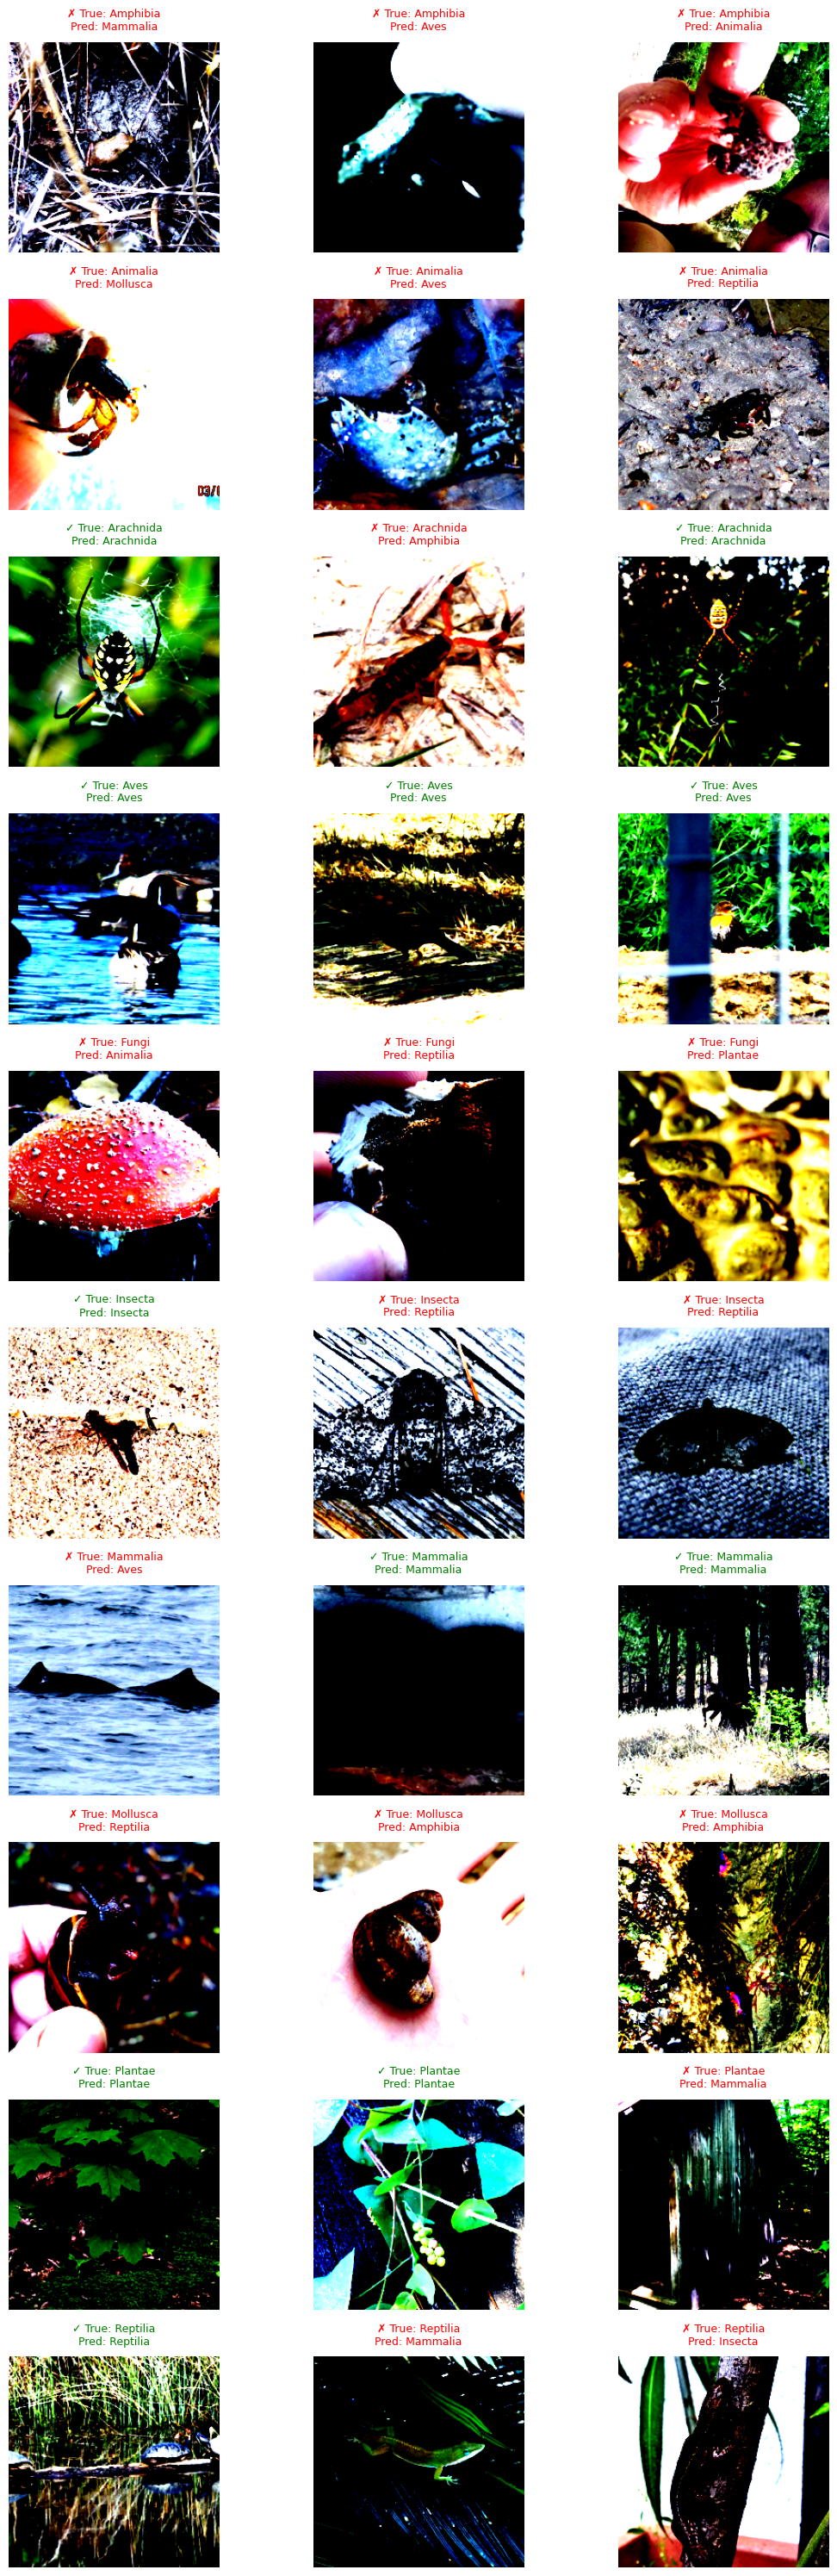